In [1]:
"""Script for optimization of a single topology"""
import multiprocess
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.moo.kgb import KGB
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import (
    TwoLinkGenerator,
    visualize_constrains,
)

from auto_robot_design.optimization.saver import (
    ProblemSaver,
)
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import (
    draw_joint_point,
)
from auto_robot_design.optimization.problems import (
    CalculateCriteriaProblemByWeigths,
    CalculateCriteriaMeanMultiTraj,
    CalculateCriteriaMeanTraj,
    get_optimizing_joints,
)
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import (
    ActuatedMass,
    EffectiveInertiaCompute,
    ImfCompute,
    ManipCompute,
    MovmentSurface,
    NeutralPoseMass,
    TranslationErrorMSE,
    ManipJacobian,
)
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import (
    convert_x_y_to_6d_traj_xz,
    get_simple_spline,
    get_vertical_trajectory,
    create_simple_step_trajectory,
)
from auto_robot_design.optimization.rewards.reward_base import PositioningReward
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import (
    HeavyLiftingReward,
    AccelerationCapability,
)
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import (
    EndPointZRRReward,
    VelocityReward,
    ForceEllipsoidReward,
)
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import (
    TMotor_AK10_9,
    TMotor_AK60_6,
    TMotor_AK70_10,
    TMotor_AK80_64,
    TMotor_AK80_9,
)
from auto_robot_design.description.builder import (
    ParametrizedBuilder,
    DetailedURDFCreatorFixedEE,
    jps_graph2pinocchio_robot,
)

### Parametrization

#### 1) mechanism configuration

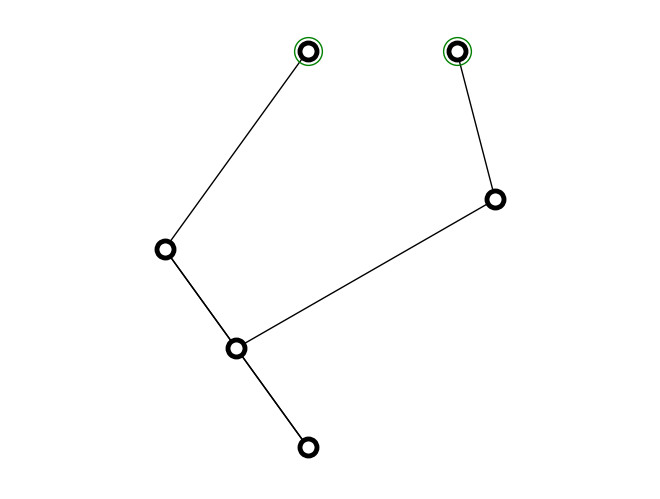

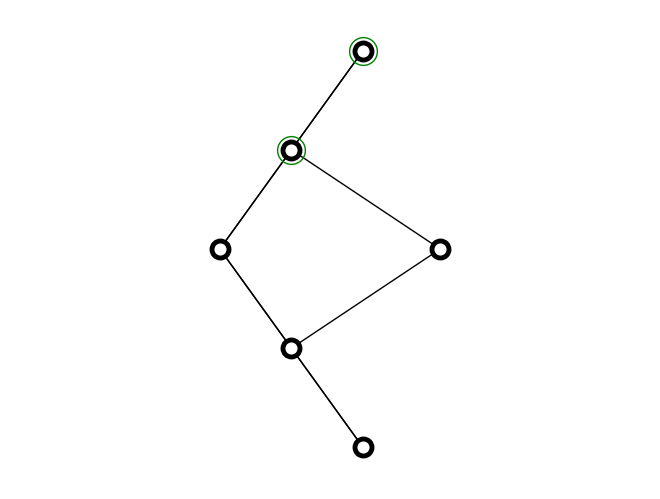

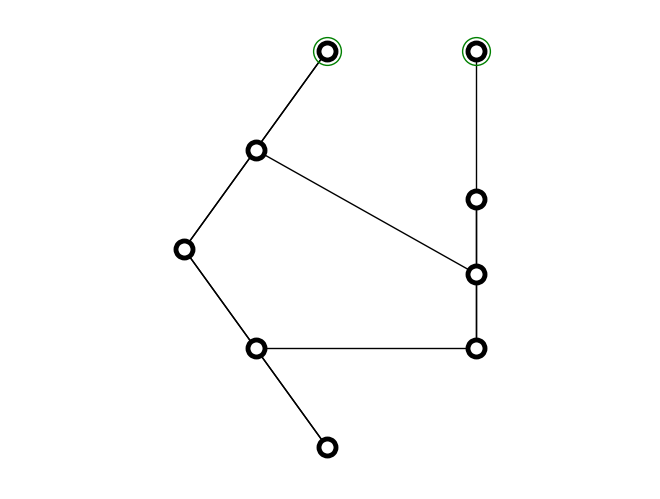

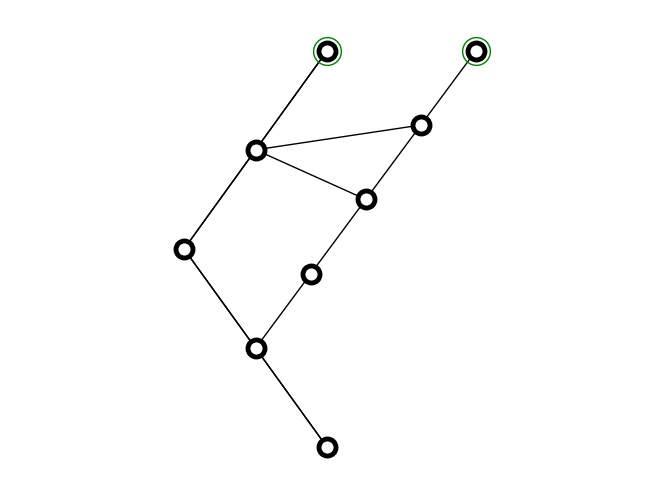

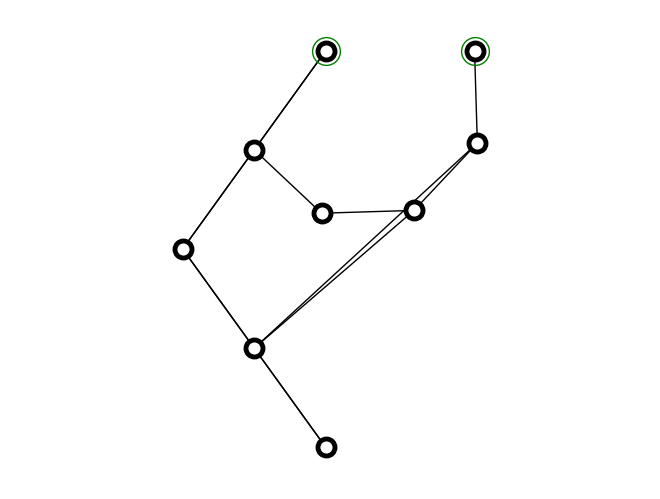

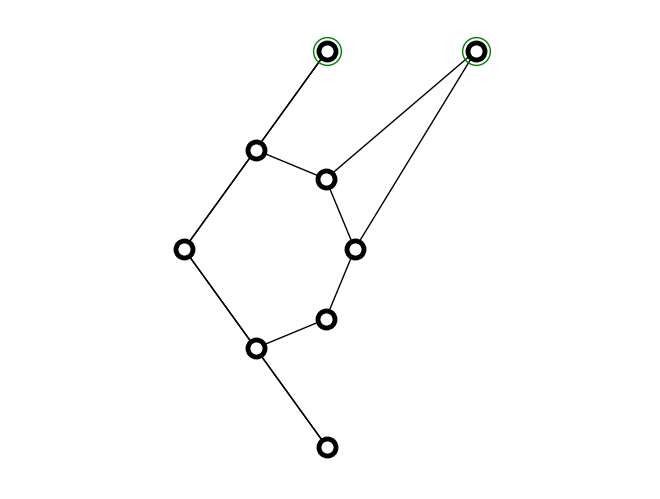

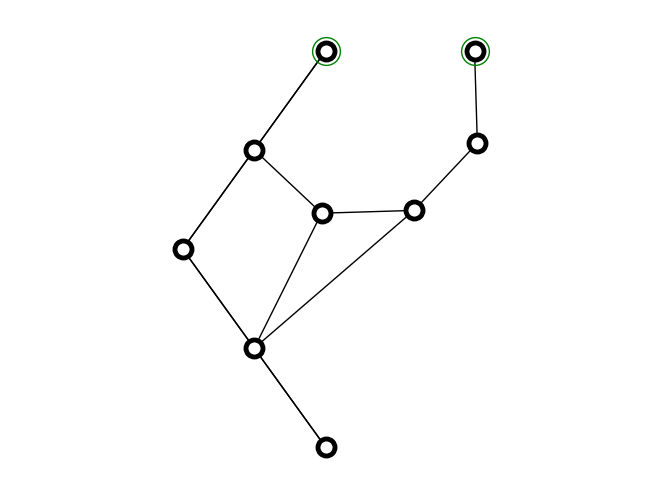

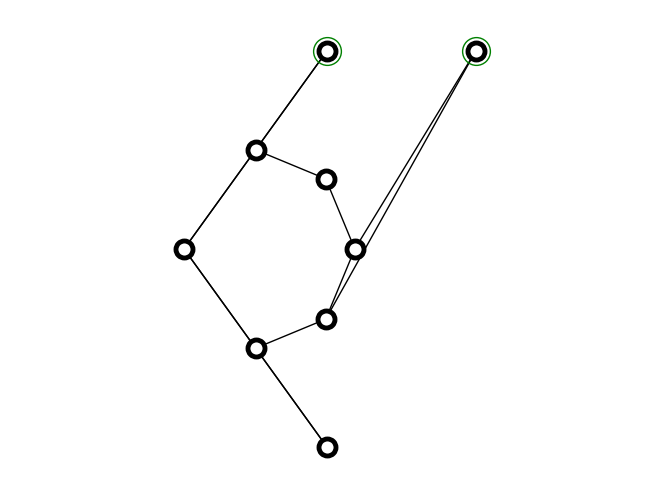

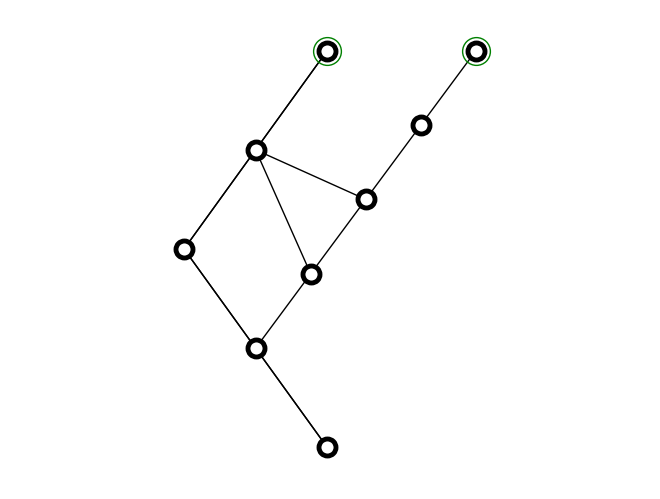

In [2]:
generator = TwoLinkGenerator()
all_graphs = generator.get_standard_set(knee_pos = -0.4, shift=0.3)

for id, (graph, constr) in enumerate(all_graphs):
    if id >= 9:
        plt.figure()
        draw_joint_point(graph)
        plt.savefig("./results/graphs/graph_" + str(id+1) + ".svg")


In [ ]:


actuator = TMotor_AK10_9()
# actuator = TMotor_AK60_6()
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator,thickness=thickness)
# visualize_constrains(graph, constrain_dict)

#### 2) set optimization task

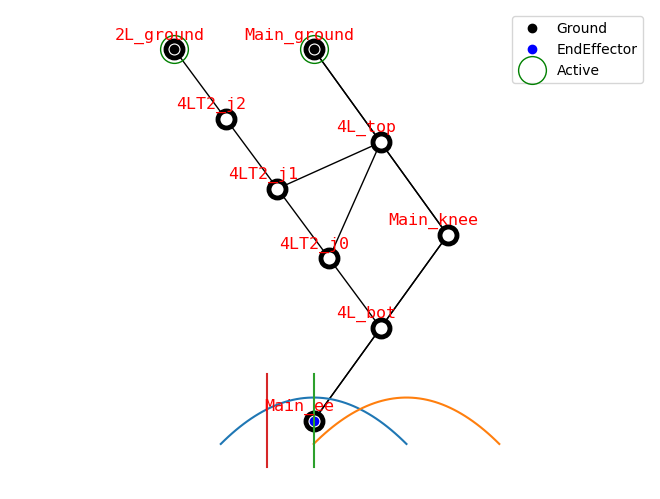

In [6]:
# trajectories
ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.2, -0.85], step_height= 0.1, step_width=0.4,n_points=50))
left_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.4, -0.85], step_height= 0.1, step_width=0.4,n_points=50))
right_shift_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(starting_point=[-0.0, -0.85], step_height= 0.1, step_width=0.4,n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, 0,50))
left_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, -0.1,50))
right_vertical = convert_x_y_to_6d_traj_xz(*get_vertical_trajectory(-0.9, 0.2, 0.1,50))

# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
rewards_step = [(PositioningReward(pos_error_key="POS_ERR"), 1e6), (AccelerationCapability(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass"), 1)]

step_trajectories = [ground_symmetric_step,left_shift_step,right_shift_step]
step_trajectories = [ground_symmetric_step, right_shift_step]

rewards_vertical = [(PositioningReward(pos_error_key="POS_ERR"), 1e6),
           (HeavyLiftingReward(manipulability_key='Manip_Jacobian',
            trajectory_key="traj_6d", error_key="error", mass_key="MASS"), 1)]

vertical_trajectories = [central_vertical, left_vertical, right_vertical]
vertical_trajectories = [central_vertical, left_vertical]

rewards_and_trajectories = [(rewards_step, step_trajectories),(rewards_vertical, vertical_trajectories)]


draw_joint_point(graph)

for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])

#### Calculate rewards for initial graph.

In [7]:
# create builder
thickness = 0.04
builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE, size_ground=np.array(
    [thickness*5, thickness*10, thickness*2]), actuator=actuator, thickness=thickness)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder)

crag = CriteriaAggregator(
    dict_point_criteria, dict_trajectory_criteria)

fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
partial_rewards = []
for rewards, trajectories in rewards_and_trajectories:
    mean_reward = np.zeros(len(trajectories))
    mean_partial = np.zeros((len(trajectories),len(rewards)))
    for trajectory_id, trajectory in enumerate(trajectories):
        point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
        current_total = 0
        current_partial = []
        for reward, weight in rewards:
            current_partial.append(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator=actuator)[0])
            current_total += weight*current_partial[-1]
            print(reward.__class__.__name__, current_partial[-1])
        mean_reward[trajectory_id] = current_total
        mean_partial[trajectory_id] = current_partial
    total_reward = np.mean(mean_reward)
    partial_rewards.append([total_reward]+list(np.mean(mean_partial, axis=0)))
    print(f"Rewards: {[reward.__class__.__name__ for reward, _ in rewards]}")
    print('Total reward:', total_reward.round(5), 'partial rewards at best trajectory:', partial_rewards[-1][1:])


PositioningReward -0.0474188872036652
AccelerationCapability 0
PositioningReward -0.1972339805398457
AccelerationCapability 0
Rewards: ['PositioningReward', 'AccelerationCapability']
Total reward: -122326.43387 partial rewards at best trajectory: [-0.12232643387175546, 0.0]
PositioningReward -0.03845797304312315
HeavyLiftingReward 0
PositioningReward -0.009554387853577396
HeavyLiftingReward 0
Rewards: ['PositioningReward', 'HeavyLiftingReward']
Total reward: -24006.18045 partial rewards at best trajectory: [-0.024006180448350272, 0.0]


In [8]:
# activate multiprocessing
N_PROCESS = 8
pool = multiprocess.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

# the result is the dict with key - joint_point, value - tuple of all possible coordinate moves
optimizing_joints = get_optimizing_joints(graph, constrain_dict)

In [9]:
population_size = 32
n_generations = 20

# create the problem for the current optimization
problem = CalculateCriteriaMeanTraj(graph,builder=builder,
                                            jp2limits=optimizing_joints,
                                            crag = crag,
                                            rewards_and_trajectories=rewards_and_trajectories,
                                            elementwise_runner=runner, 
                                            Actuator = actuator)
# problem = CalculateCriteriaMeanMultiTraj(graph,builder=builder,
#                                             jp2limits=optimizing_joints,
#                                             crag = crag,
#                                             rewards_and_trajectories=rewards_and_trajectories,
#                                             elementwise_runner=runner, Actuator = actuator)


In [10]:

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = PSO(pop_size=population_size, save_history=True)
# algorithm = KGB(save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 1,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })


n_gen  |  n_eval  |    f     |    S    |    w    |    c1    |    c2    |     f_avg     |     f_min    
     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  2.864086E+04 | -1.627248E+01
     2 |       64 |  0.33238 |       2 |  0.6127 |  2.03389 |  1.96611 |  1.150082E+04 | -2.093974E+01
     3 |       96 | -3.8E-02 |       3 |  0.3764 |  2.03346 |  1.97921 |  5.829997E+03 | -2.187837E+01
     4 |      128 | -3.2E-02 |       3 |  0.3805 |  2.02640 |  2.00084 |  1.824884E+03 | -2.187837E+01
     5 |      160 | -2.9E-02 |       3 |  0.3818 |  2.01243 |  2.01538 |  3.010841E+02 | -3.097613E+01
     6 |      192 |  0.33712 |       2 |  0.6156 |  2.03071 |  1.97622 |  1.592428E+02 | -3.589175E+01
     7 |      224 |  0.14105 |       3 |  0.4903 |  2.02662 |  1.99659 |  1.584291E+02 | -3.589175E+01
     8 |      256 |  0.09818 |       3 |  0.4625 |  2.01466 |  2.00949 |  1.577197E+02 | -3.589175E+01
     9 |      288 |  0.02254 |       3 |  0.4141 |  2.00253 |  2.01989 | 

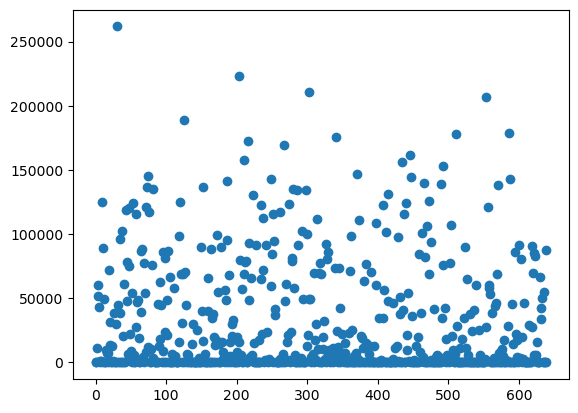

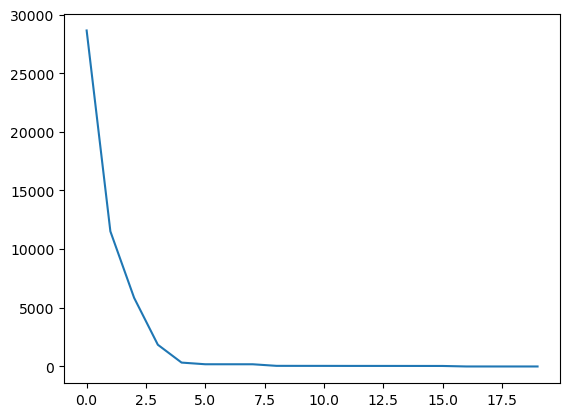

In [11]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)),flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)),history_mean)
plt.show()

In [12]:
worst_id = np.argmax(optimizer.history["F"])
worst_reward = optimizer.history["F"][worst_id]
print('The maximum result in optimization task:', worst_reward.item())

The maximum result in optimization task: 261706.75062401744


The minimum result in optimization task: [-44.19286132]


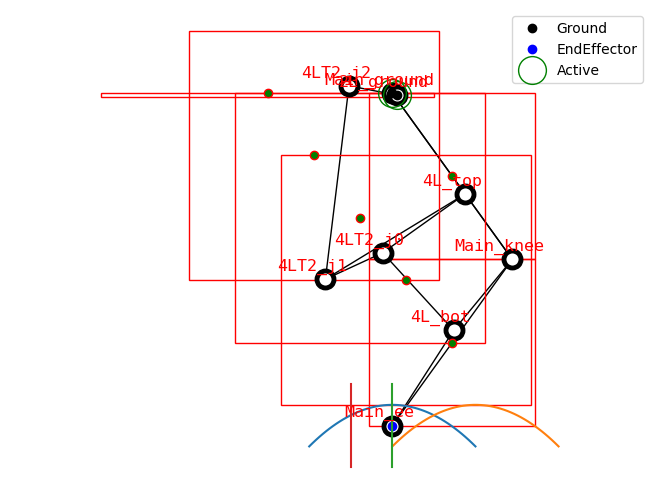

In [13]:
best_id = np.argmin(optimizer.history["F"])
best_x = optimizer.history["X"][best_id]
best_reward = optimizer.history["F"][best_id]
print("The minimum result in optimization task:", best_reward)

problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

problem.mutate_JP_by_xopt(problem.initial_xopt)
for _, trajectories in rewards_and_trajectories:
    for trajectory in trajectories:
        plt.plot(trajectory[:,0],trajectory[:,2])
visualize_constrains(problem.graph, constrain_dict)


In [14]:
valid_arr_x_args = list(filter(lambda x: np.isclose(np.array(optimizer.history["Fs"])[x,0,1], 0), range(len(optimizer.history["Fs"])) ))

valid_arr_x = np.array(optimizer.history["X"])[valid_arr_x_args, :]
valid_arr_AC = np.array(optimizer.history["Fs"])[valid_arr_x_args, 0, 2]

valid_arr_X_AC = list(zip(valid_arr_x, valid_arr_AC))
valid_arr_X_AC_srtd = sorted(valid_arr_X_AC, key=lambda X_AC: X_AC[1])


In [15]:
best_reward_decomposition = optimizer.history["Fs"][best_id]
best_reward_decomposition

array([[22.07889973,  0.        , 22.07889973],
       [22.11396159,  0.        , 22.11396159]])

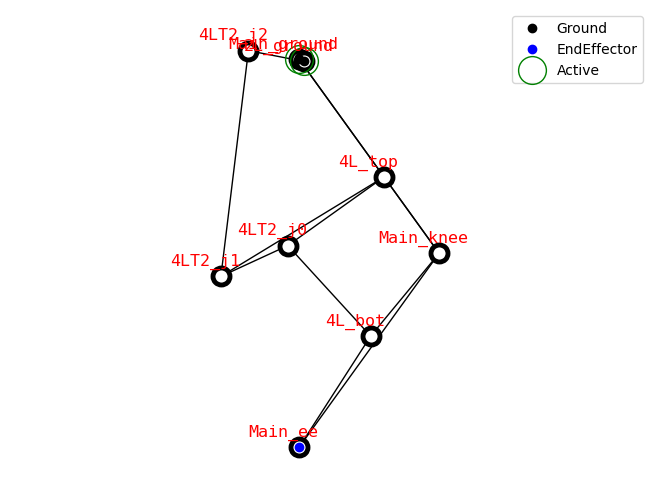

In [16]:
problem.mutate_JP_by_xopt(best_x)
draw_joint_point(problem.graph)

21.908269405030307
24.14520311054103


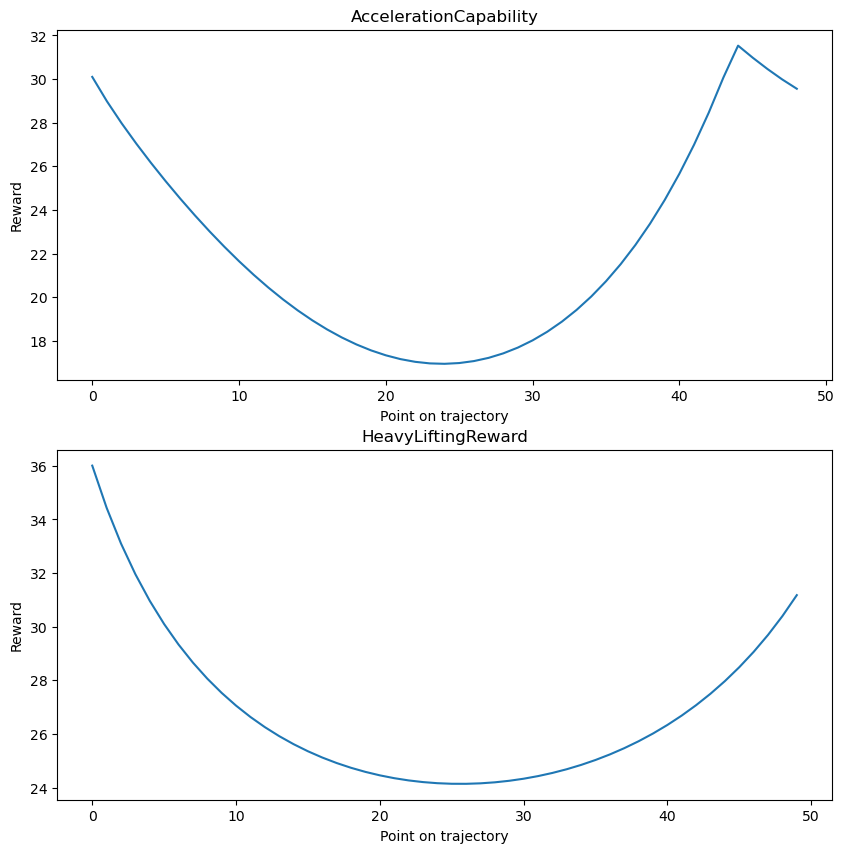

In [17]:
fixed_robot, free_robot = jps_graph2pinocchio_robot(problem.graph, builder=builder)
fig, axs, = plt.subplots(len(best_reward_decomposition),1, figsize=(10,10))
for i, ax, reward_decomposition in zip(range(len(best_reward_decomposition)), axs, best_reward_decomposition):
    trajectory = rewards_and_trajectories[i][1][0]


    point_criteria_vector, trajectory_criteria, res_dict_fixed = crag.get_criteria_data(fixed_robot, free_robot, trajectory)
    reward = rewards_and_trajectories[i][0][1][0]

    print(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[0])
    reward_vector = np.array(reward.calculate(point_criteria_vector, trajectory_criteria, res_dict_fixed, Actuator = actuator)[1])
    ax.plot(reward_vector)
    ax.set_title(reward.__class__.__name__)
    ax.set_xlabel('Point on trajectory')
    ax.set_ylabel('Reward')
    reward_vector
plt.show()

In [18]:
len(valid_arr_X_AC)

252

In [21]:
coeffs = []

In [18]:
len(coeffs)

0

In [19]:

problem.mutate_JP_by_xopt(best_x)
# problem.mutate_JP_by_xopt(problem.initial_xopt)
compare_id = [15, 50, 100, 200, -1]
[valid_arr_X_AC_srtd[id][1] for id in compare_id]

[5.6455790947136055,
 11.917916038549745,
 16.83676374658026,
 21.725690672608597,
 27.697106178161533]

In [20]:
[x_kp_kp[0] for x_kp_kp in coeffs]

NameError: name 'coeffs' is not defined

In [22]:

from auto_robot_design.simulation.trajectory_movments import TrajectoryMovements   
import auto_robot_design.simulation.evaluation as eval
import os
import dill
x_vars = [valid_arr_X_AC_srtd[id][0] for id in compare_id]



data = []
for x_var in x_vars:
    problem.mutate_JP_by_xopt(x_var)
    robo, __ = jps_graph2pinocchio_robot(problem.graph, builder)

    name_ee = "EE"

    # traj = vertical_trajectories[0][:,[0,2]]
    traj =  step_trajectories[0][:,[0,2]]
    test = TrajectoryMovements(traj, 0.8, 0.001, name_ee)

    time_arr, des_traj_6d, __ = test.prepare_trajectory(robo)
    # test.prepare_trajectory(robo)
    opt_ctrl_x_arr = [x_kp_kp[0] for x_kp_kp in coeffs]
    if opt_ctrl_x_arr and np.all(x_var == opt_ctrl_x_arr, axis=1).any():
        id_ctrl = np.argwhere(np.all(x_var == opt_ctrl_x_arr, axis=1)).squeeze()
        Kp = coeffs[id_ctrl][1]
        Kd = coeffs[id_ctrl][2]
    else:
        Kp, Kd = test.optimize_control(robo)
        coeffs.append((x_var, Kp, Kd))

    test.Kp = Kp
    test.Kd = Kd
    
    # # q, vq, acc, tau, pos_ee, power
    data.append(test.simulate(robo, False))


     1 |        5 |        - |       - |  0.9000 |  2.00000 |  2.00000 |  1.000422E+06 |  1.518367E+03


/home/yefim-work/Documents/Be2rLab/CoDesign/auto-robotics-design/auto_robot_design/simulation/trajectory_movments.py:250: RuntimeWarning: overflow encountered in multiply
  power[i] = tau_a * vq_a
/home/yefim-work/miniconda3/envs/j_moves/lib/python3.9/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real


     2 |       10 | -2.3E+00 |       3 |  0.0018 |  2.00000 |  2.02253 |  1.000422E+06 |  1.518367E+03
     3 |       15 | -1.5E-01 |       3 |  0.3135 |  1.98901 |  2.03541 |  9.751774E+04 |  1.513675E+03
     4 |       20 | -8.2E-02 |       3 |  0.3499 |  1.97736 |  2.04727 |  1.027195E+04 |  1.513675E+03
     5 |       25 | -2.1E-01 |       3 |  0.2797 |  1.96599 |  2.06134 |  6.906147E+03 |  1.513675E+03
     6 |       30 | -3.5E-01 |       3 |  0.2101 |  1.95367 |  2.07497 |  3.138198E+03 |  1.267250E+03
     7 |       35 |  0.14311 |       3 |  0.4917 |  1.94107 |  2.08768 |  3.138198E+03 |  1.267250E+03
     8 |       40 | -2.8E-01 |       3 |  0.2449 |  1.92859 |  2.09748 |  1.297982E+03 |  6.648236E+02
     9 |       45 |  0.10489 |       3 |  0.4669 |  1.91797 |  2.11097 |  1.288244E+03 |  6.161328E+02
    10 |       50 | -4.5E-01 |       3 |  0.1698 |  1.90646 |  2.12461 |  1.249959E+03 |  6.161328E+02
     1 |        5 |        - |       - |  0.9000 |  2.00000 |  2.00000 | 

In [23]:

pathfile_ctrl = os.path.join(saver.path, "ctrl_coeffs.pkl")

with open(pathfile_ctrl, "wb") as f:
    dill.dump(coeffs, f)


In [24]:
len(coeffs)

5

In [28]:
coeffs[np.argwhere(np.all(x_var == opt_ctrl_x_arr, axis=1)).squeeze()]

TypeError: only integer scalar arrays can be converted to a scalar index

In [25]:
power_arrs = [data[i][5] for i in range(len(data))]
pos_ee_arrs = [data[i][4] for i in range(len(data))]
tau_arrs = [data[i][3] for i in range(len(data))]


In [26]:
for power in power_arrs:
    print(np.abs(power).sum(), power.sum())

47470.504800259034 2745.0622209771927
7789.76726620347 2884.0292474269845
7153.0753945650085 3183.699184569709
5232.662166857717 2006.3547712760442
5276.9227364132985 1411.2000390071669


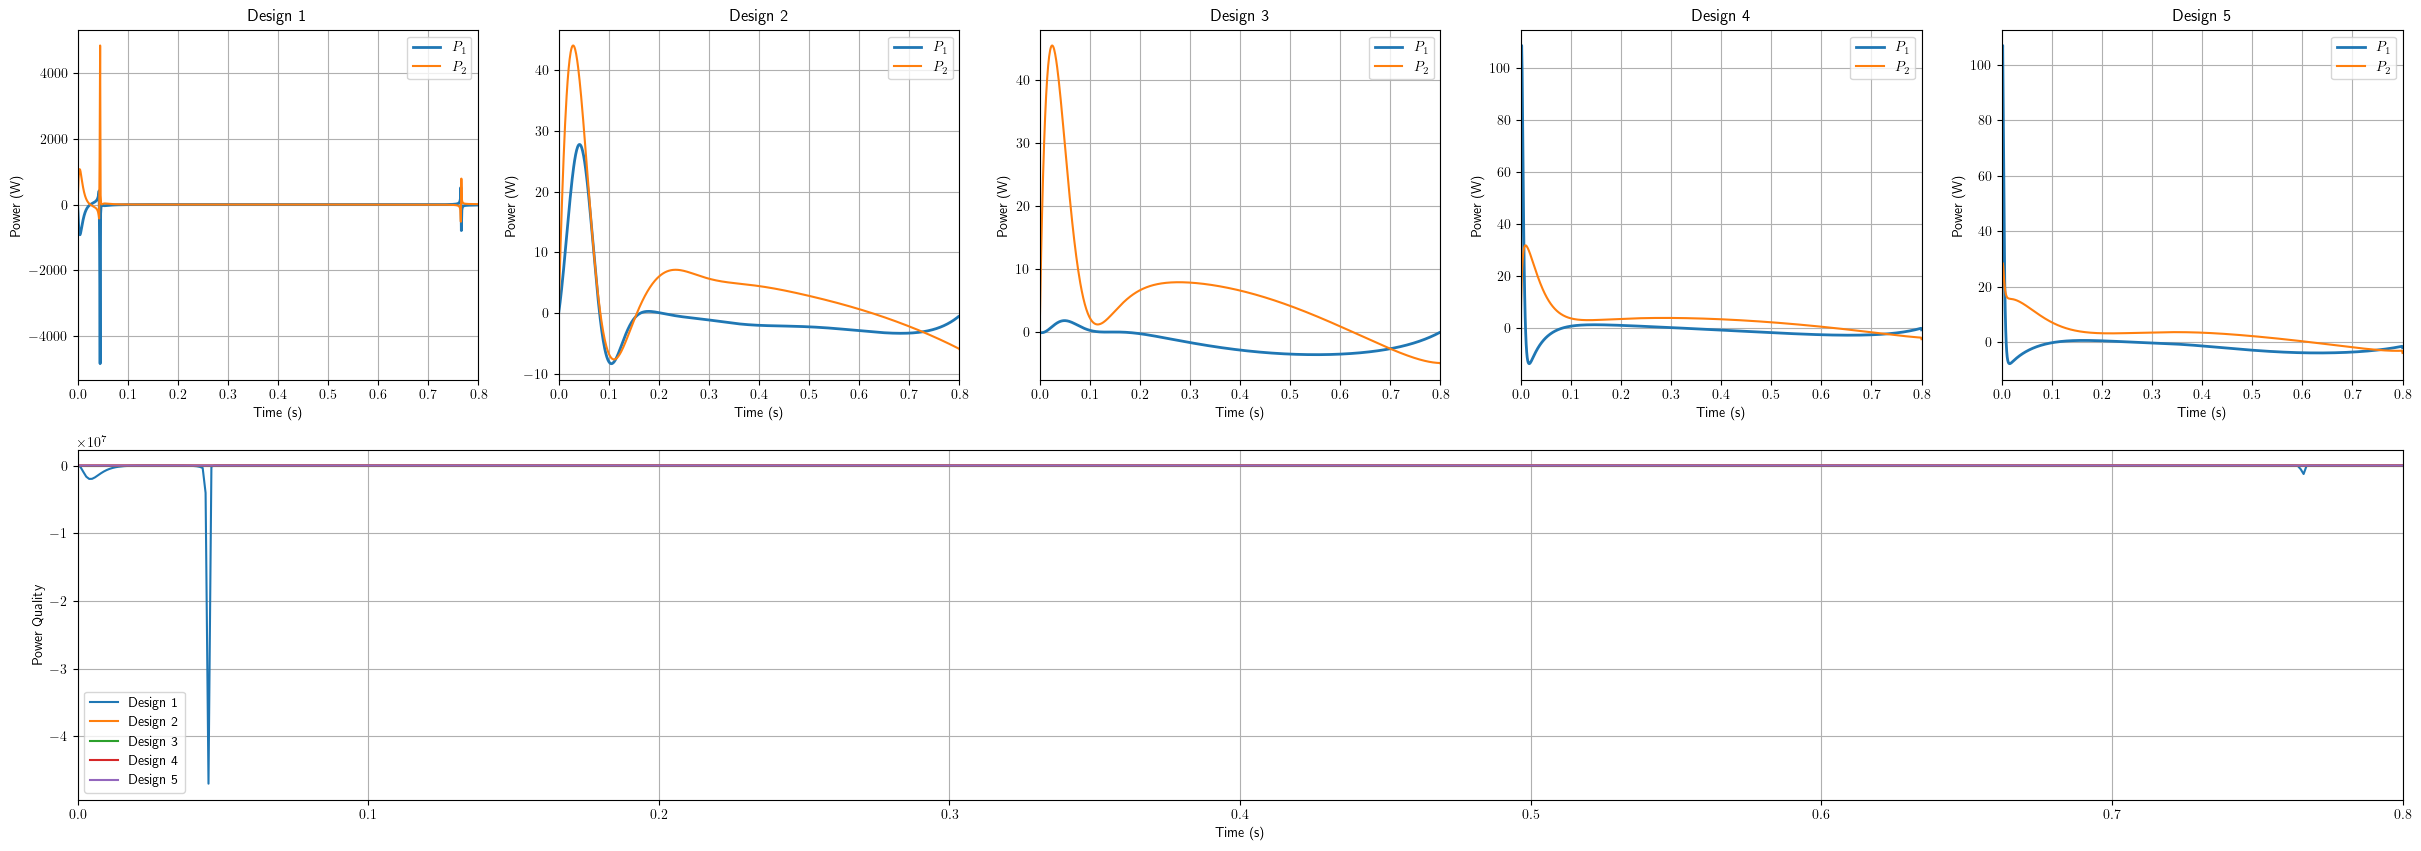

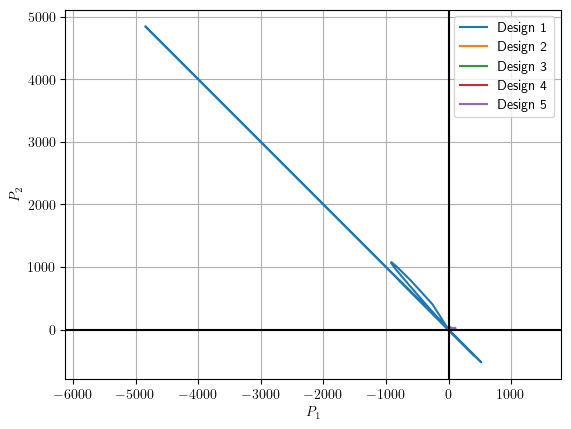

PQ: (array([59.338131  ,  9.73720908,  8.94134424,  6.54082771,  6.59615342]), array([2745.06222098, 2884.02924743, 3183.69918457, 2006.35477128,
       1411.20003901]), array([47470.50480026,  7789.7672662 ,  7153.07539457,  5232.66216686,
        5276.92273641]))


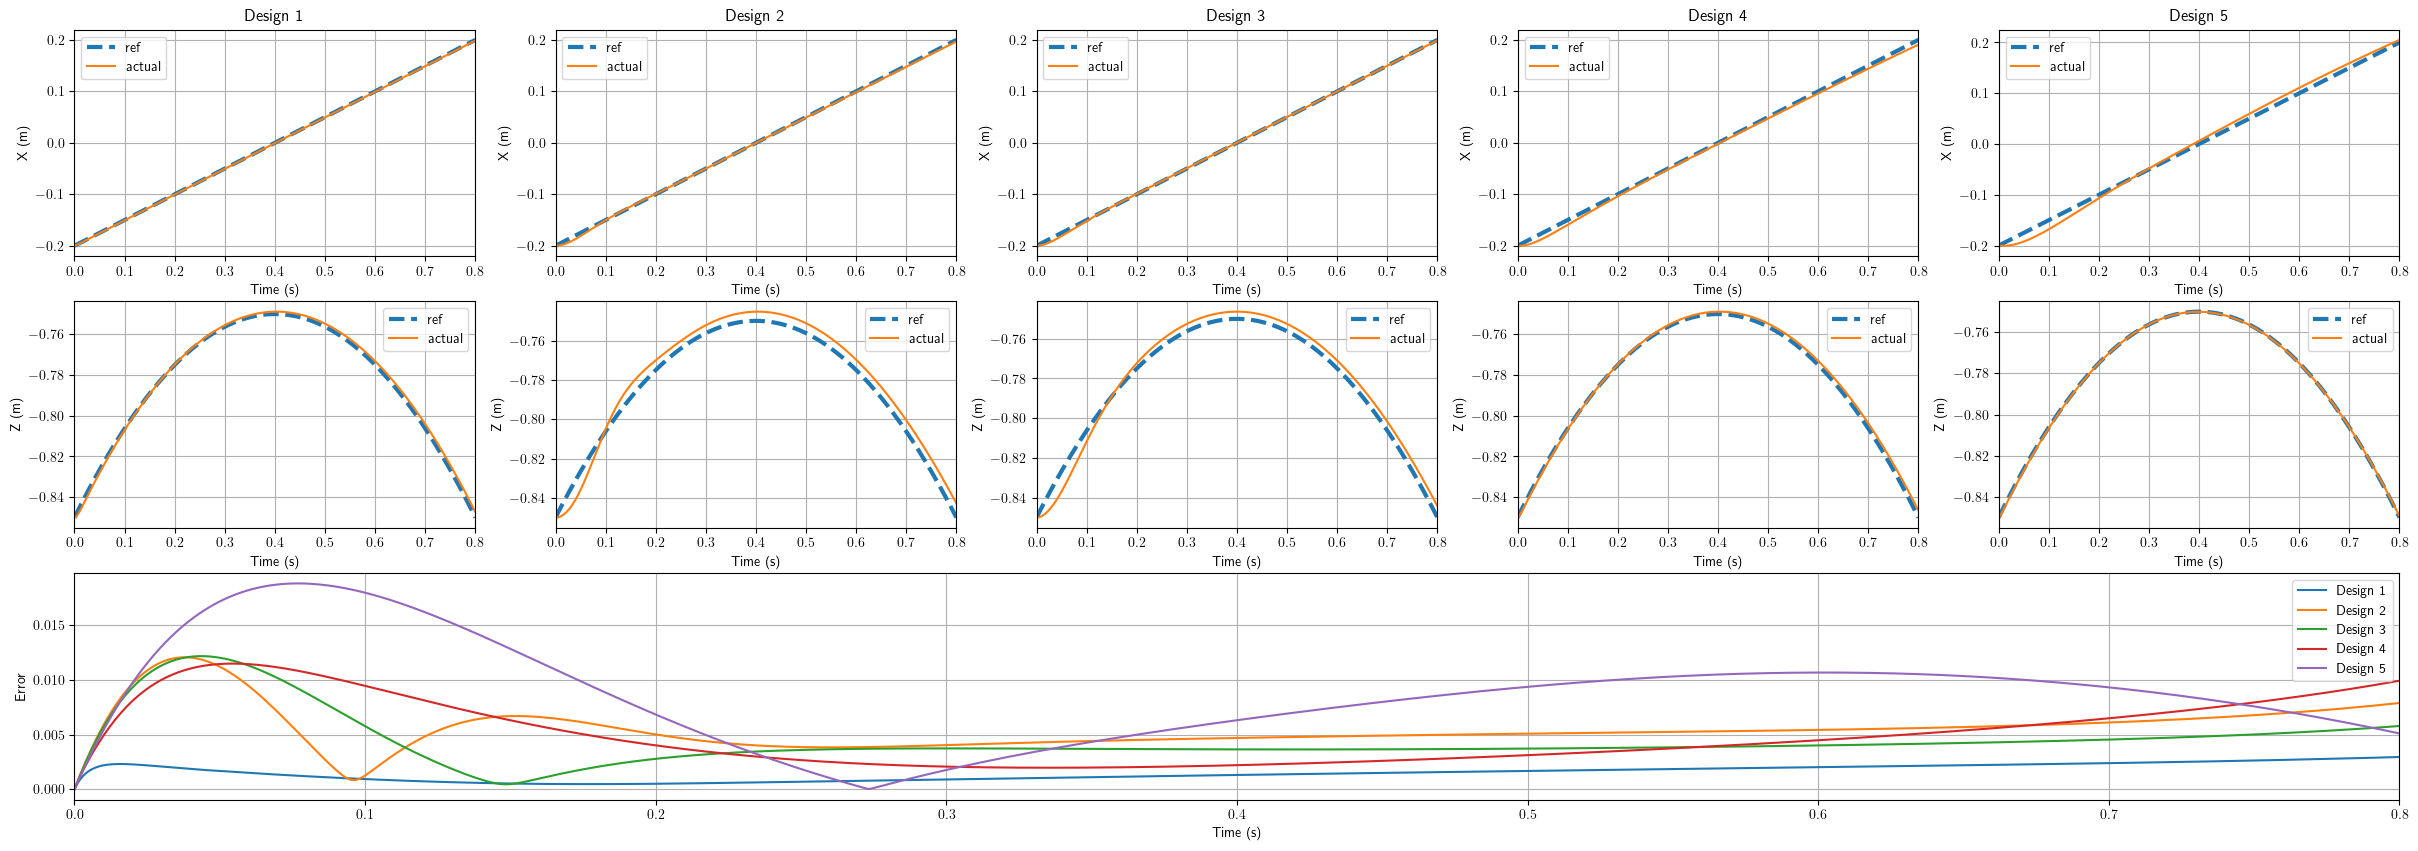

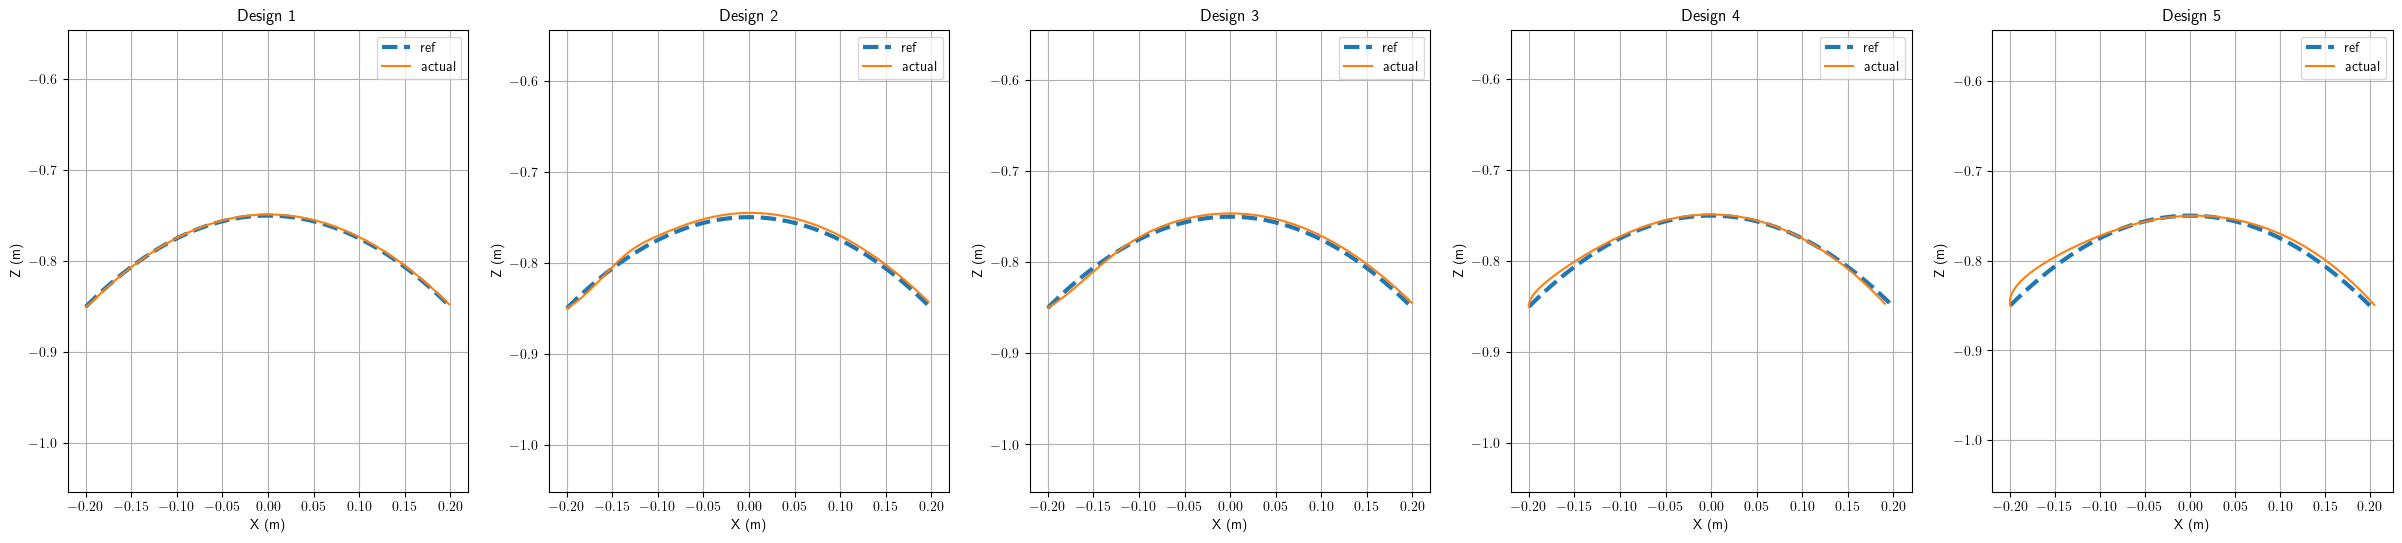

Error [0.00152495 0.00550106 0.00441234 0.00506222 0.00871433]


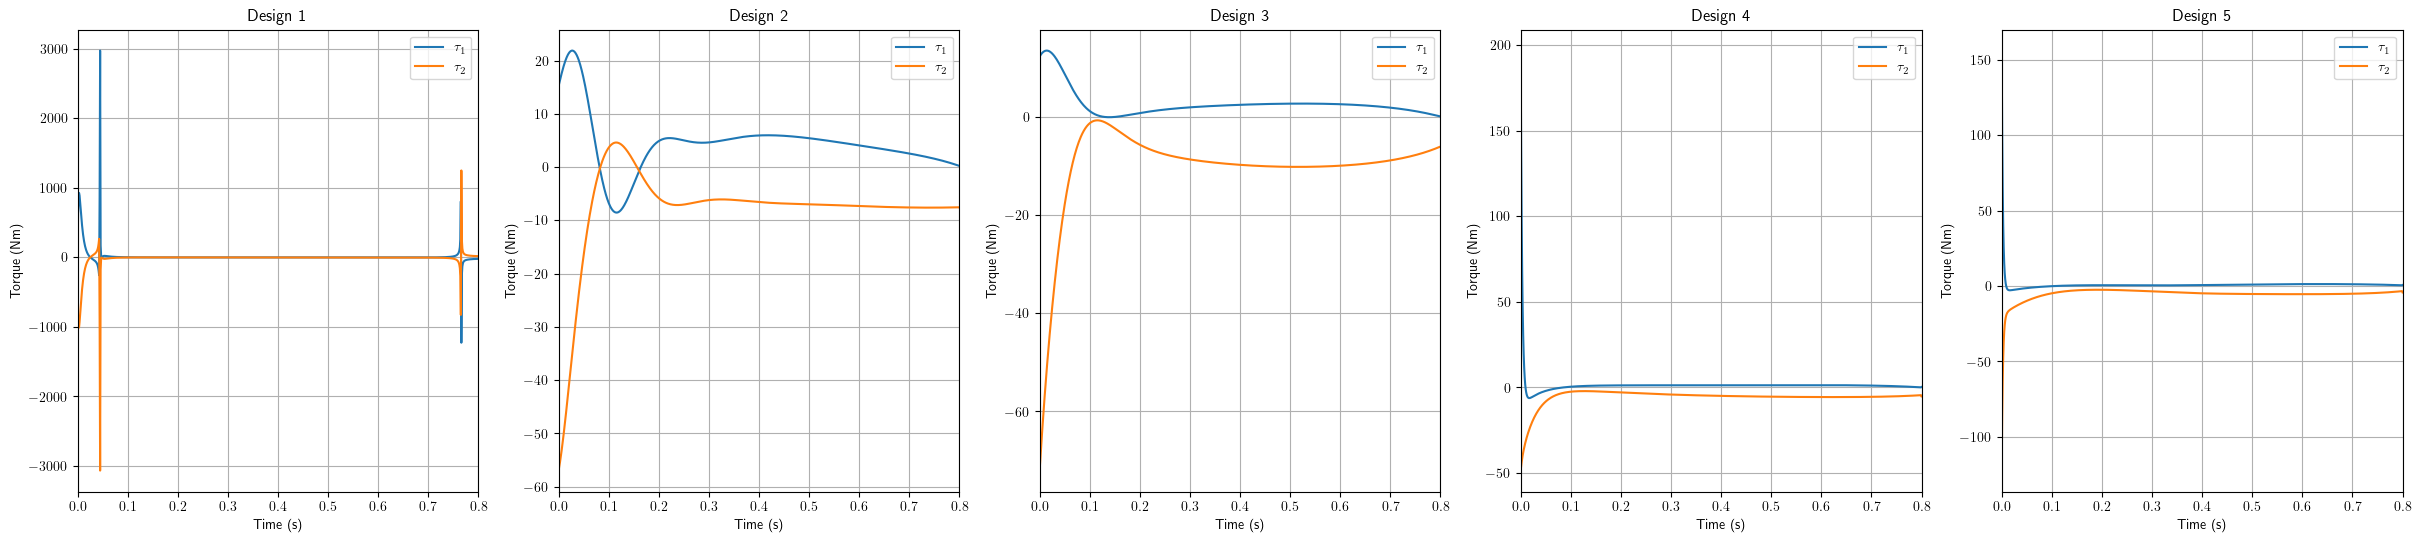

Max Torque (array([[2971.04108277, 3065.49856043],
       [  21.87348977,   56.97241436],
       [  13.44600525,   72.03668043],
       [ 196.76491569,   48.56242681],
       [ 156.04134232,  122.35058982]]), array([[24.80525574, 27.59324413],
       [ 5.47298403,  8.33942307],
       [ 2.5720302 , 10.17212646],
       [ 2.03535922,  5.64275332],
       [ 1.34652895,  5.53877707]]))


In [27]:

print(f"PQ: {eval.compare_power_quality(time_arr, power_arrs, True)}")
print(f"Error {eval.compare_movments_in_xz_plane(time_arr, pos_ee_arrs, des_traj_6d[:,:3], True)}")
print(f"Max Torque {eval.compare_torque_evaluation(time_arr, tau_arrs, True)}")

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


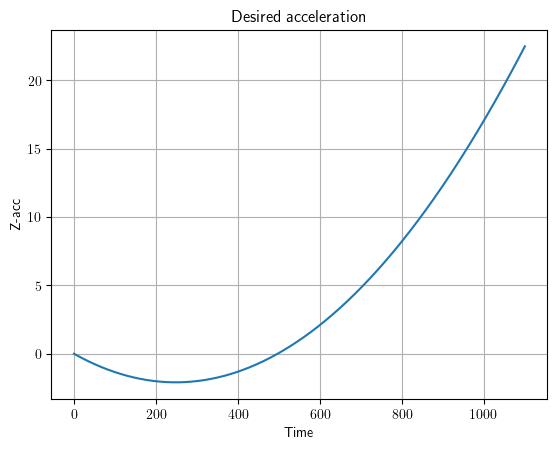

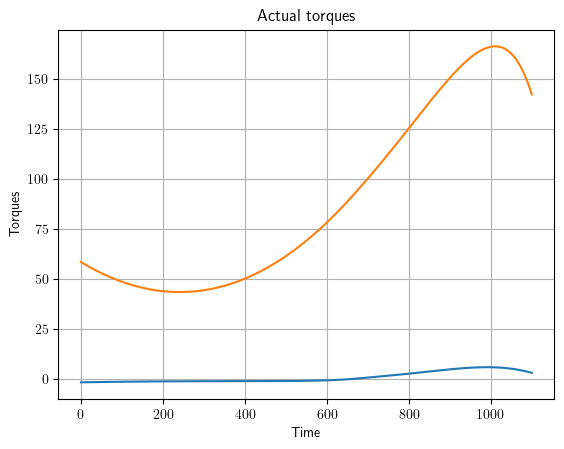

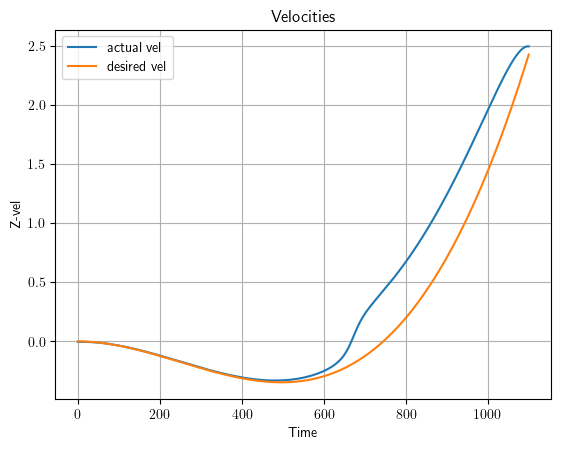

In [30]:
from auto_robot_design.description.builder import jps_graph2urdf_by_bulder
from auto_robot_design.pinokla.squat import SquatHopParameters, SimulateSquatHop

problem.mutate_JP_by_xopt(best_x)
robo_urdf, joint_description, loop_description = jps_graph2urdf_by_bulder(
    graph, builder)

sqh_p = SquatHopParameters(hop_flight_hight=0.3,
                           squatting_up_hight=0,
                           squatting_down_hight=-0.1,
                           total_time=0.55)
hoppa = SimulateSquatHop(sqh_p)


q_act, vq_act, acc_act, tau = hoppa.simulate(
    robo_urdf, joint_description, loop_description, is_vis=True)

trj_f = hoppa.create_traj_equation()
t = np.linspace(0, sqh_p.total_time,  len(q_act))
list__234 = np.array(list(map(trj_f, t)))


plt.figure()
plt.plot(list__234[:, 2])
plt.title("Desired acceleration")
plt.xlabel("Time")
plt.ylabel("Z-acc")
plt.grid(True)

plt.figure()
plt.plot(tau[:, 0])
plt.plot(tau[:, 1])
plt.title("Actual torques")
plt.xlabel("Time")
plt.ylabel("Torques")
plt.grid(True)


plt.figure()

plt.plot(vq_act[:, 0])
plt.plot(list__234[:, 1])
plt.title("Velocities")
plt.xlabel("Time")
plt.ylabel("Z-vel")
plt.legend(["actual vel", "desired vel"])
plt.grid(True)

plt.show()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


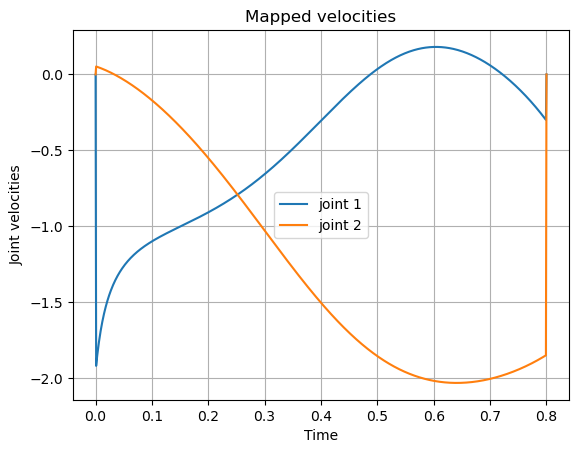

In [27]:
from auto_robot_design.pinokla.criterion_agregator import calculate_quasi_static_simdata
from pinocchio.visualize import MeshcatVisualizer
import meshcat

problem.mutate_JP_by_xopt(best_x)
trajectory = rewards_and_trajectories[0][1][1]

viz = MeshcatVisualizer(robo.model, robo.visual_model, robo.visual_model)
viz.viewer = meshcat.Visualizer().open()
viz.clean()
viz.loadViewerModel()
fixed_robot, free_robot = jps_graph2pinocchio_robot(graph, builder=builder)
res_dict_free, res_dict_fixed = calculate_quasi_static_simdata(free_robot, fixed_robot, crag.end_effector_name, des_traj_6d, viz)

des_traj_6d_tangent = np.diff(des_traj_6d, axis=0)
for i in range(1, len(des_traj_6d_tangent)):
    des_traj_6d_tangent[i] = des_traj_6d_tangent[i] / np.linalg.norm(des_traj_6d_tangent[i])
arr_Jclosed = res_dict_fixed["J_closed"] 

des_traj_6d_tangent = np.vstack([des_traj_6d_tangent, np.zeros(6)])

q_mapped = np.zeros((len(des_traj_6d_tangent), 2))
for i in range(len(des_traj_6d_tangent)):
    q_mapped[i] = np.linalg.pinv(arr_Jclosed[i]) @ des_traj_6d_tangent[i]

q_mapped[:,0] = np.array([q_mapped[i,0] if np.abs(q_mapped[i,0]) <= 10 else 10 for i in range(len(q_mapped))])
q_mapped[:,1] = np.array([q_mapped[i,1] if np.abs(q_mapped[i,1]) <= 10 else 10 for i in range(len(q_mapped))])
plt.figure()
plt.plot(time_arr,q_mapped[:, 0])
plt.plot(time_arr,q_mapped[:, 1])
plt.title("Mapped velocities")
plt.xlabel("Time")
plt.ylabel("Joint velocities")
plt.legend(["joint 1", "joint 2"])
plt.grid(True)
plt.show()